# 1. Modulos

In [24]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import openpyxl

# 2. Rutas 

In [25]:
# Validados
#R_NS = r"C:\Users\crist\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\NS\NS validado\all-NS-VAL.txt"
R_NS = r"C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\NS\NS validado\all-NS-VAL.txt"
R_NS_neg = r"C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\NS\NS Negado\all-NS-NEG.txt"
# Glosados
#R_NS = r"C:\Users\crist\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\Procesos BDUA\Subsidiados\Procesos BDUA EPS\NS\NS Negado\all-NS-NEG.txt"

# 3. Cargue Datafarmes 

In [26]:
df_ns = pd.read_csv(R_NS, sep=',', dtype=str, encoding='latin-1')
df_ns_neg = pd.read_csv(R_NS_neg, sep=',', dtype=str, encoding='latin-1')
# Convertir Fecha_Proceso a datetime y filtrar desde enero 2024
df_ns['Fecha_Proceso'] = pd.to_datetime(df_ns['Fecha_Proceso'], format='%d/%m/%Y')
df_ns = df_ns[df_ns['Fecha_Proceso'] >= '2022-01-01']
df_ns = df_ns.sort_values(by='NOVEDAD', ascending=False)

# 4. Validar
## 4.1. Columnas

In [27]:
df_ns.columns

Index(['Nombre_Archivo', 'NUM_SOLICITUD_NOVEDAD', 'ENT_ID', 'TPS_IDN_ID',
       'HST_IDN_NUMERO_IDENTIFICACION', 'AFL_PRIMER_APELLIDO',
       'AFL_SEGUNDO_APELLIDO', 'AFL_PRIMER_NOMBRE', 'AFL_SEGUNDO_NOMBRE',
       'AFL_FECHA_NACIMIENTO', 'MNC_ID', 'NOVEDAD', 'FECHA_NOVEDAD',
       'COD_1_NOVEDAD', 'COD_2_NOVEDAD', 'COD_3_NOVEDAD', 'COD_4_NOVEDAD',
       'COD_5_NOVEDAD', 'COD_6_NOVEDAD', 'COD_7_NOVEDAD', 'Fecha_Proceso'],
      dtype='object')

## 4.2. Numero de registros por novedad

In [28]:
df_ns['NOVEDAD'].value_counts().sort_index()

NOVEDAD
N01      2720
N02      1103
N03       856
N04      6606
N09      1049
N12       311
N14      4530
N17       112
N19     30997
N20         3
N21    179528
N25     71370
N31      3045
N32      5781
N36       290
N39     19686
N41      3014
N43      7567
N46     15709
Name: count, dtype: int64

## 4.3. N14 Actualización o cambio de estado de afiliación

In [29]:
# Filtrar registros donde NOVEDAD es N14
df_n14 = df_ns[df_ns['NOVEDAD'] == 'N14']

# Obtener un registro por cada grupo de COD_1_NOVEDAD
muestra_n14 = df_n14.groupby('COD_1_NOVEDAD').first().reset_index()

print(f"Total de grupos distintos en COD_1_NOVEDAD para N14: {len(muestra_n14)}")
print("\nRegistros de muestra (1 por cada COD_1_NOVEDAD):")
print(muestra_n14)

Total de grupos distintos en COD_1_NOVEDAD para N14: 3

Registros de muestra (1 por cada COD_1_NOVEDAD):
  COD_1_NOVEDAD        Nombre_Archivo NUM_SOLICITUD_NOVEDAD  ENT_ID  \
0            RE  NSEPS02504112022.VAL                   196  EPS025   
1            SD  NSEPS02524102025.VAL                   124  EPS025   
2            SM  NSEPS02517102025.VAL                   115  EPS025   

  TPS_IDN_ID HST_IDN_NUMERO_IDENTIFICACION AFL_PRIMER_APELLIDO  \
0         CC                    1006414936                TUAY   
1         CN                23018410313172              VILERA   
2         PT                       1117116             RENGIFO   

  AFL_SEGUNDO_APELLIDO AFL_PRIMER_NOMBRE AFL_SEGUNDO_NOMBRE  ... MNC_ID  \
0              NARANJO           WILFRAN              DAVID  ...  85250   
1                LOPEZ           HIJO DE          ALEXANDRA  ...  85250   
2            TORREALBA           OSLAIZY                LUZ  ...  85001   

  NOVEDAD FECHA_NOVEDAD COD_2_NOVEDAD COD_3_

## 4.4. N17 filtro

In [30]:
# Filtrar registros donde NOVEDAD es N17
df_n17 = df_ns[df_ns['NOVEDAD'] == 'N17']

## 4.5. N21 filtro

In [31]:
# Filtrar registros donde NOVEDAD es N21 y COD_3_NOVEDAD es diferente a '5'
df_n21 = df_ns[(df_ns['NOVEDAD'] == 'N21') & (df_ns['COD_3_NOVEDAD'] != '5')]

# 5. Estadisticas
## 5. novedades totales por año 

Tabla de registros por año:
    Año  Total Registros
0  2022            23657
1  2023           149407
2  2024            74916
3  2025           106297

Total general: 354,277 registros


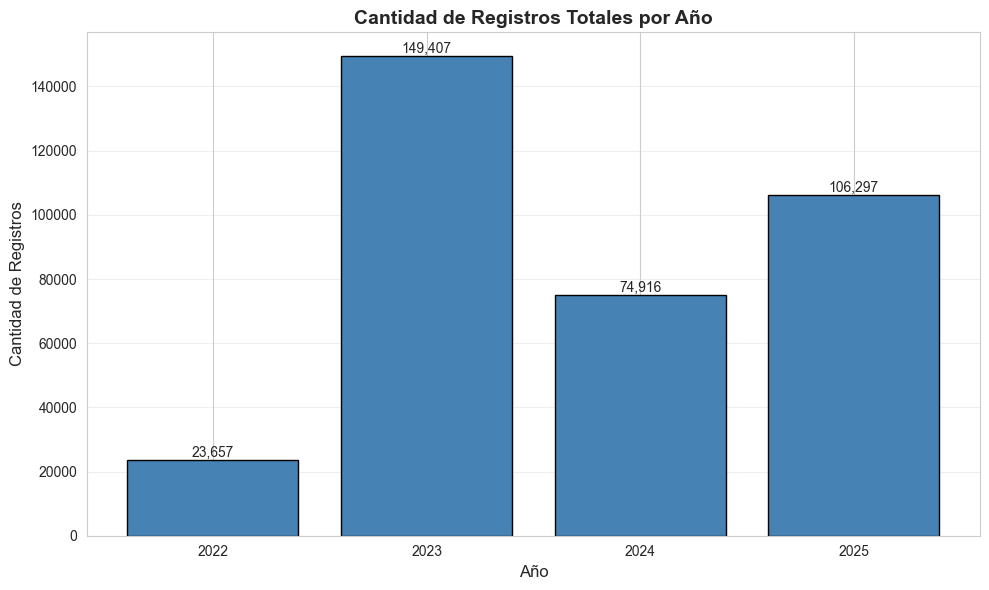

In [32]:
# Extraer el año de Fecha_Proceso y contar registros por año
registros_por_año = df_ns['Fecha_Proceso'].dt.year.value_counts().sort_index()

# Crear una tabla comparativa
tabla_años = pd.DataFrame({
    'Año': registros_por_año.index,
    'Total Registros': registros_por_año.values
})

print("Tabla de registros por año:")
print(tabla_años)
print(f"\nTotal general: {tabla_años['Total Registros'].sum():,} registros")

# Crear gráfica
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(registros_por_año.index, registros_por_año.values, color='steelblue', edgecolor='black')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)
plt.title('Cantidad de Registros Totales por Año', fontsize=14, fontweight='bold')
plt.xticks(registros_por_año.index)
plt.grid(axis='y', alpha=0.3)

# Añadir valores encima de las barras
for año, cantidad in zip(registros_por_año.index, registros_por_año.values):
    plt.text(año, cantidad, f'{cantidad:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Registros por mes y año:
Año     2022    2023   2024    2025   Total
Mes                                        
1       2650     809   1096    3354    7909
2        411     853   6399    3810   11473
3        899    1515  27607    2506   32527
4        757     971   3041    6818   11587
5        414    1863  19553    4456   26286
6        505    1252   1298    4332    7387
7        566    1029   1060    3658    6313
8        392    9457   1875    5742   17466
9       1179    2468   2736    5206   11589
10     14001   86111   2073   12674  114859
11       692   41240   3893   53741   99566
12      1191    1839   4285       0    7315
Total  23657  149407  74916  106297  354277


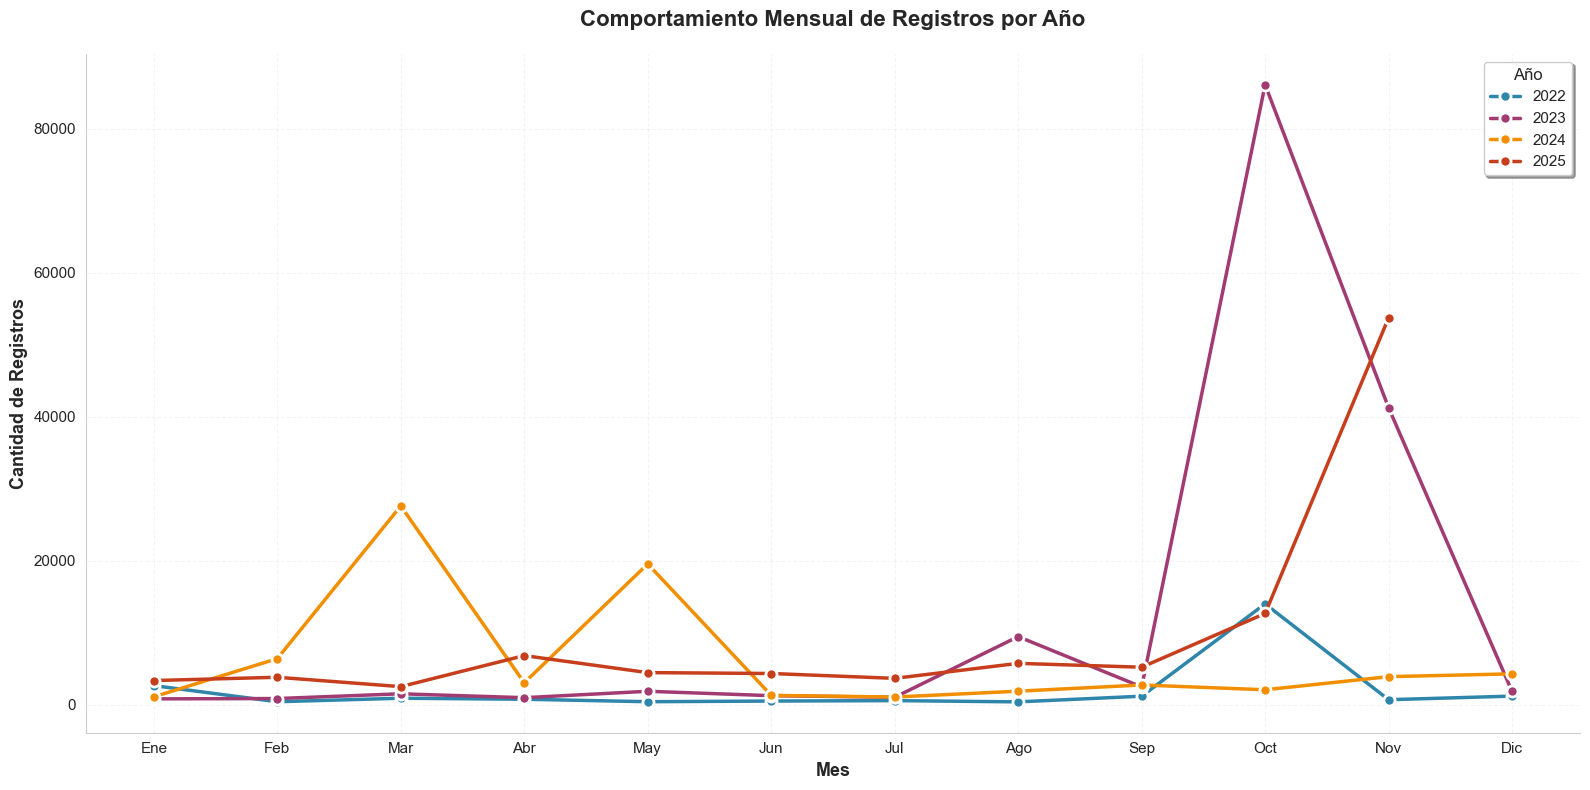

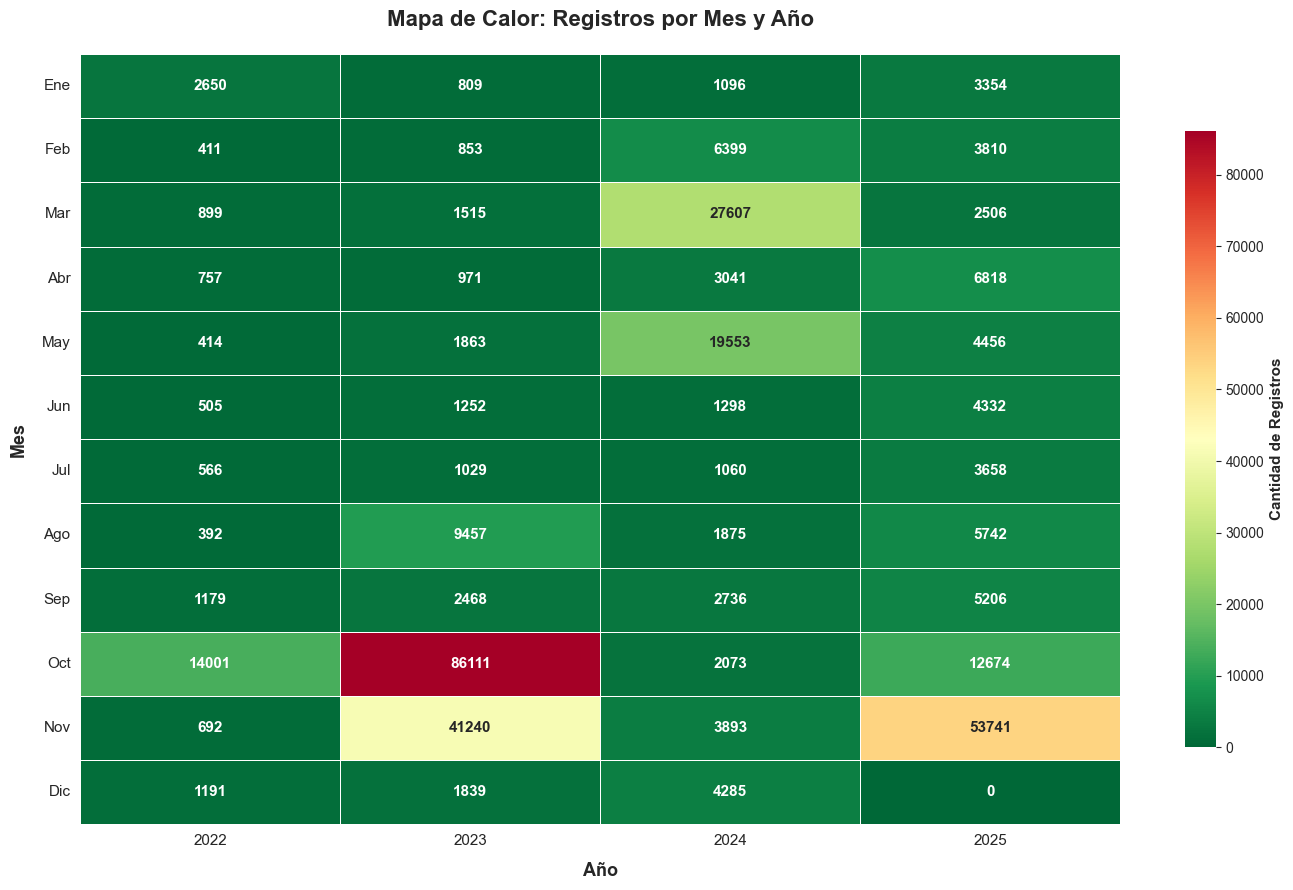

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo general
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Extraer mes y año de Fecha_Proceso
df_ns['Mes'] = df_ns['Fecha_Proceso'].dt.month
df_ns['Año'] = df_ns['Fecha_Proceso'].dt.year
df_ns['Año_Mes'] = df_ns['Fecha_Proceso'].dt.to_period('M')

# Crear tabla de registros por mes y año
registros_mes_año = pd.crosstab(df_ns['Mes'], df_ns['Año'], margins=True, margins_name='Total')

print("Registros por mes y año:")
print(registros_mes_año)

# Definir paleta de colores personalizada
colores = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Crear gráfica de líneas mejorada
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Graficar cada año con estilo mejorado
for idx, año in enumerate(sorted(df_ns['Año'].unique())):
    datos_año = df_ns[df_ns['Año'] == año].groupby('Mes').size()
    plt.plot(datos_año.index, datos_año.values, 
             marker='o', label=f'{año}', linewidth=2.5, 
             color=colores[idx % len(colores)], markersize=8,
             markeredgewidth=2, markeredgecolor='white')

plt.xlabel('Mes', fontsize=13, fontweight='bold')
plt.ylabel('Cantidad de Registros', fontsize=13, fontweight='bold')
plt.title('Comportamiento Mensual de Registros por Año', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Año', fontsize=11, title_fontsize=12, 
           frameon=True, shadow=True, fancybox=True)
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                          'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
           fontsize=11)
plt.yticks(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, alpha=0.2, linestyle='--')
plt.tight_layout()
plt.show()

# Crear heatmap mejorado
plt.figure(figsize=(14, 9))

# Preparar datos sin totales para el heatmap
datos_heatmap = registros_mes_año.iloc[:-1, :-1]

# Crear heatmap con mejor estética
ax = sns.heatmap(datos_heatmap, annot=True, fmt='d', 
                 cmap='RdYlGn_r', linewidths=0.5, linecolor='white',
                 cbar_kws={'label': 'Cantidad de Registros', 'shrink': 0.8},
                 annot_kws={'size': 11, 'weight': 'bold'},
                 xticklabels=datos_heatmap.columns,
                 yticklabels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.xlabel('Año', fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel('Mes', fontsize=13, fontweight='bold', labelpad=10)
plt.title('Mapa de Calor: Registros por Mes y Año', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)

# Mejorar colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Cantidad de Registros', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Novedades por categorias año a año

Tabla comparativa de registros por grupo de novedad y año:
Año             2022    2023   2024    2025   Total
Grupo_Novedad                                      
N01              469     970    665     616    2720
N02              170     281    347     305    1103
N03              132     216    259     249     856
N04             1823    1599   1759    1425    6606
N09              317     172    190     370    1049
N12                0       0      0     311     311
N14              811    1040   1262    1417    4530
N17               24      41     23      24     112
N19              558     650    579   29210   30997
N20                3       0      0       0       3
N21            13936   83933  49678   31981  179528
N25             2730   52383  13216    3041   71370
N31              442    1561    815     227    3045
N32               29     234    460    5058    5781
N36                9      72     89     120     290
N39             2204    6255   5574    5653   19686
N41  

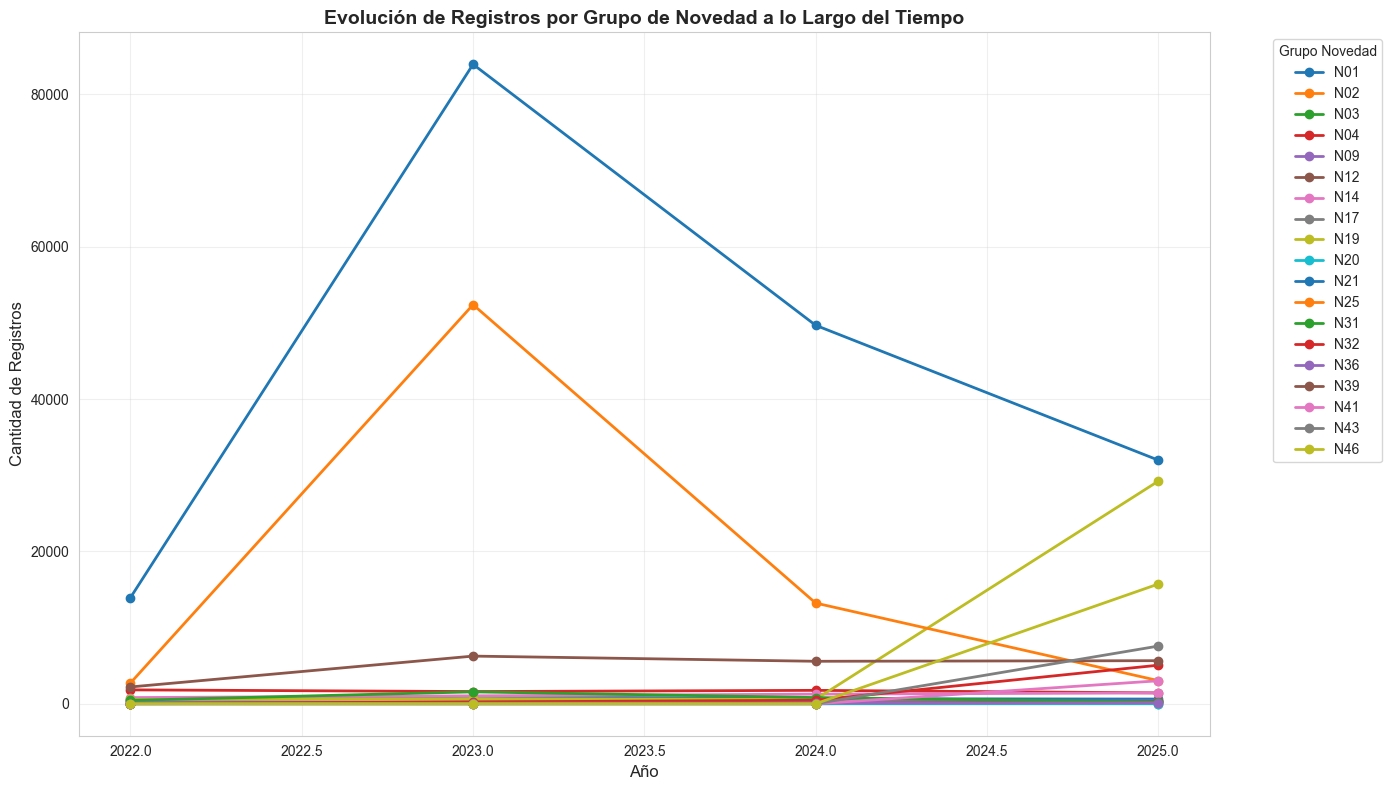

<Figure size 1400x800 with 0 Axes>

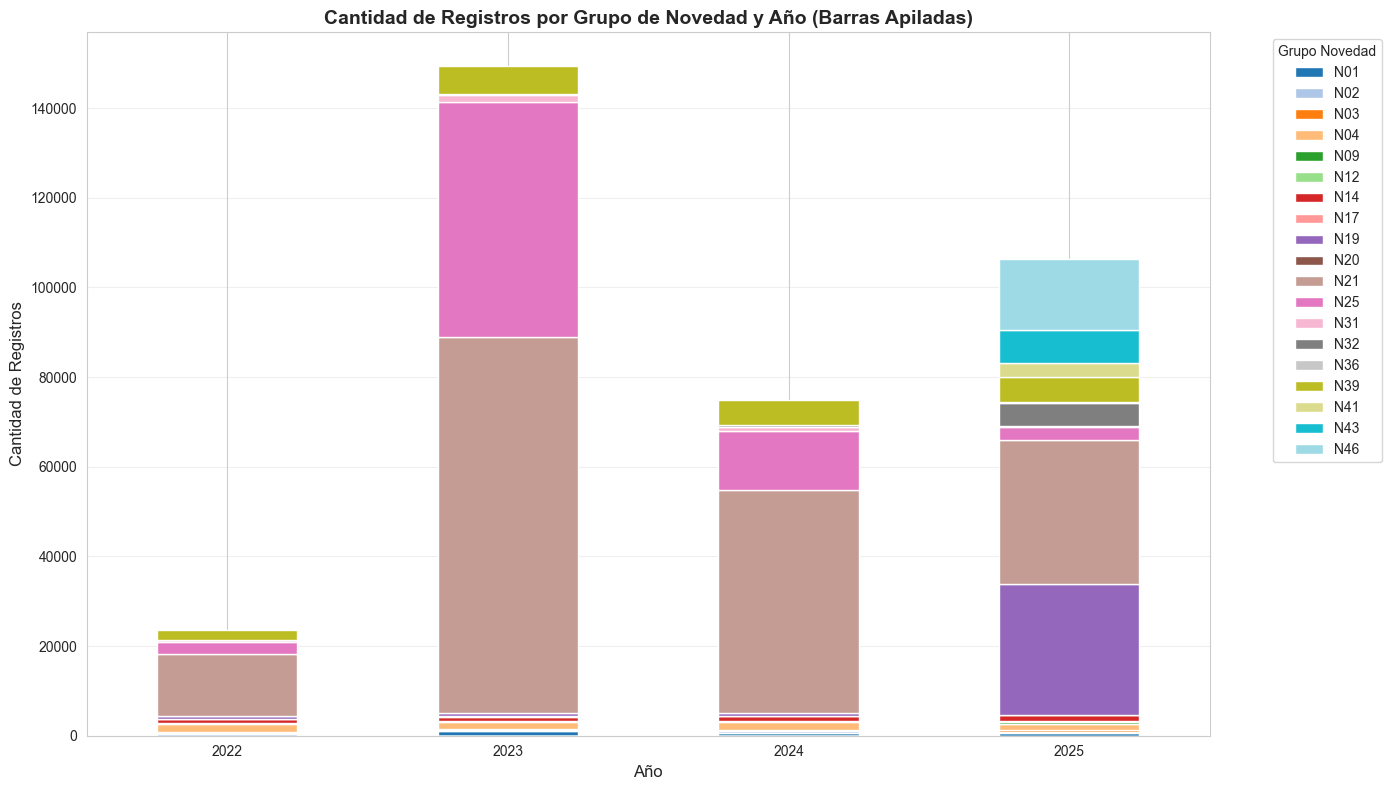

In [34]:
# Crear grupos de novedades basados en el prefijo (N01, N02, etc.)
df_ns['Grupo_Novedad'] = df_ns['NOVEDAD'].str[:3]
df_ns['Año'] = df_ns['Fecha_Proceso'].dt.year

# Crear tabla comparativa de registros por grupo de novedad y año
tabla_comparativa = pd.crosstab(df_ns['Grupo_Novedad'], df_ns['Año'], margins=True, margins_name='Total')
tabla_comparativa = tabla_comparativa.sort_index()

print("Tabla comparativa de registros por grupo de novedad y año:")
print(tabla_comparativa)
print("\n")

# Crear gráfica de líneas para ver la evolución temporal
import matplotlib.pyplot as plt

# Preparar datos para la gráfica (sin los totales)
datos_grafica = pd.crosstab(df_ns['Grupo_Novedad'], df_ns['Año'])

plt.figure(figsize=(14, 8))

# Graficar cada grupo de novedad
for grupo in datos_grafica.index:
    plt.plot(datos_grafica.columns, datos_grafica.loc[grupo], marker='o', label=grupo, linewidth=2)

plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)
plt.title('Evolución de Registros por Grupo de Novedad a lo Largo del Tiempo', fontsize=14, fontweight='bold')
plt.legend(title='Grupo Novedad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Crear gráfica de barras apiladas para comparación visual
plt.figure(figsize=(14, 8))

datos_grafica.T.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Registros', fontsize=12)
plt.title('Cantidad de Registros por Grupo de Novedad y Año (Barras Apiladas)', fontsize=14, fontweight='bold')
plt.legend(title='Grupo Novedad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Validadas VS NEgadas

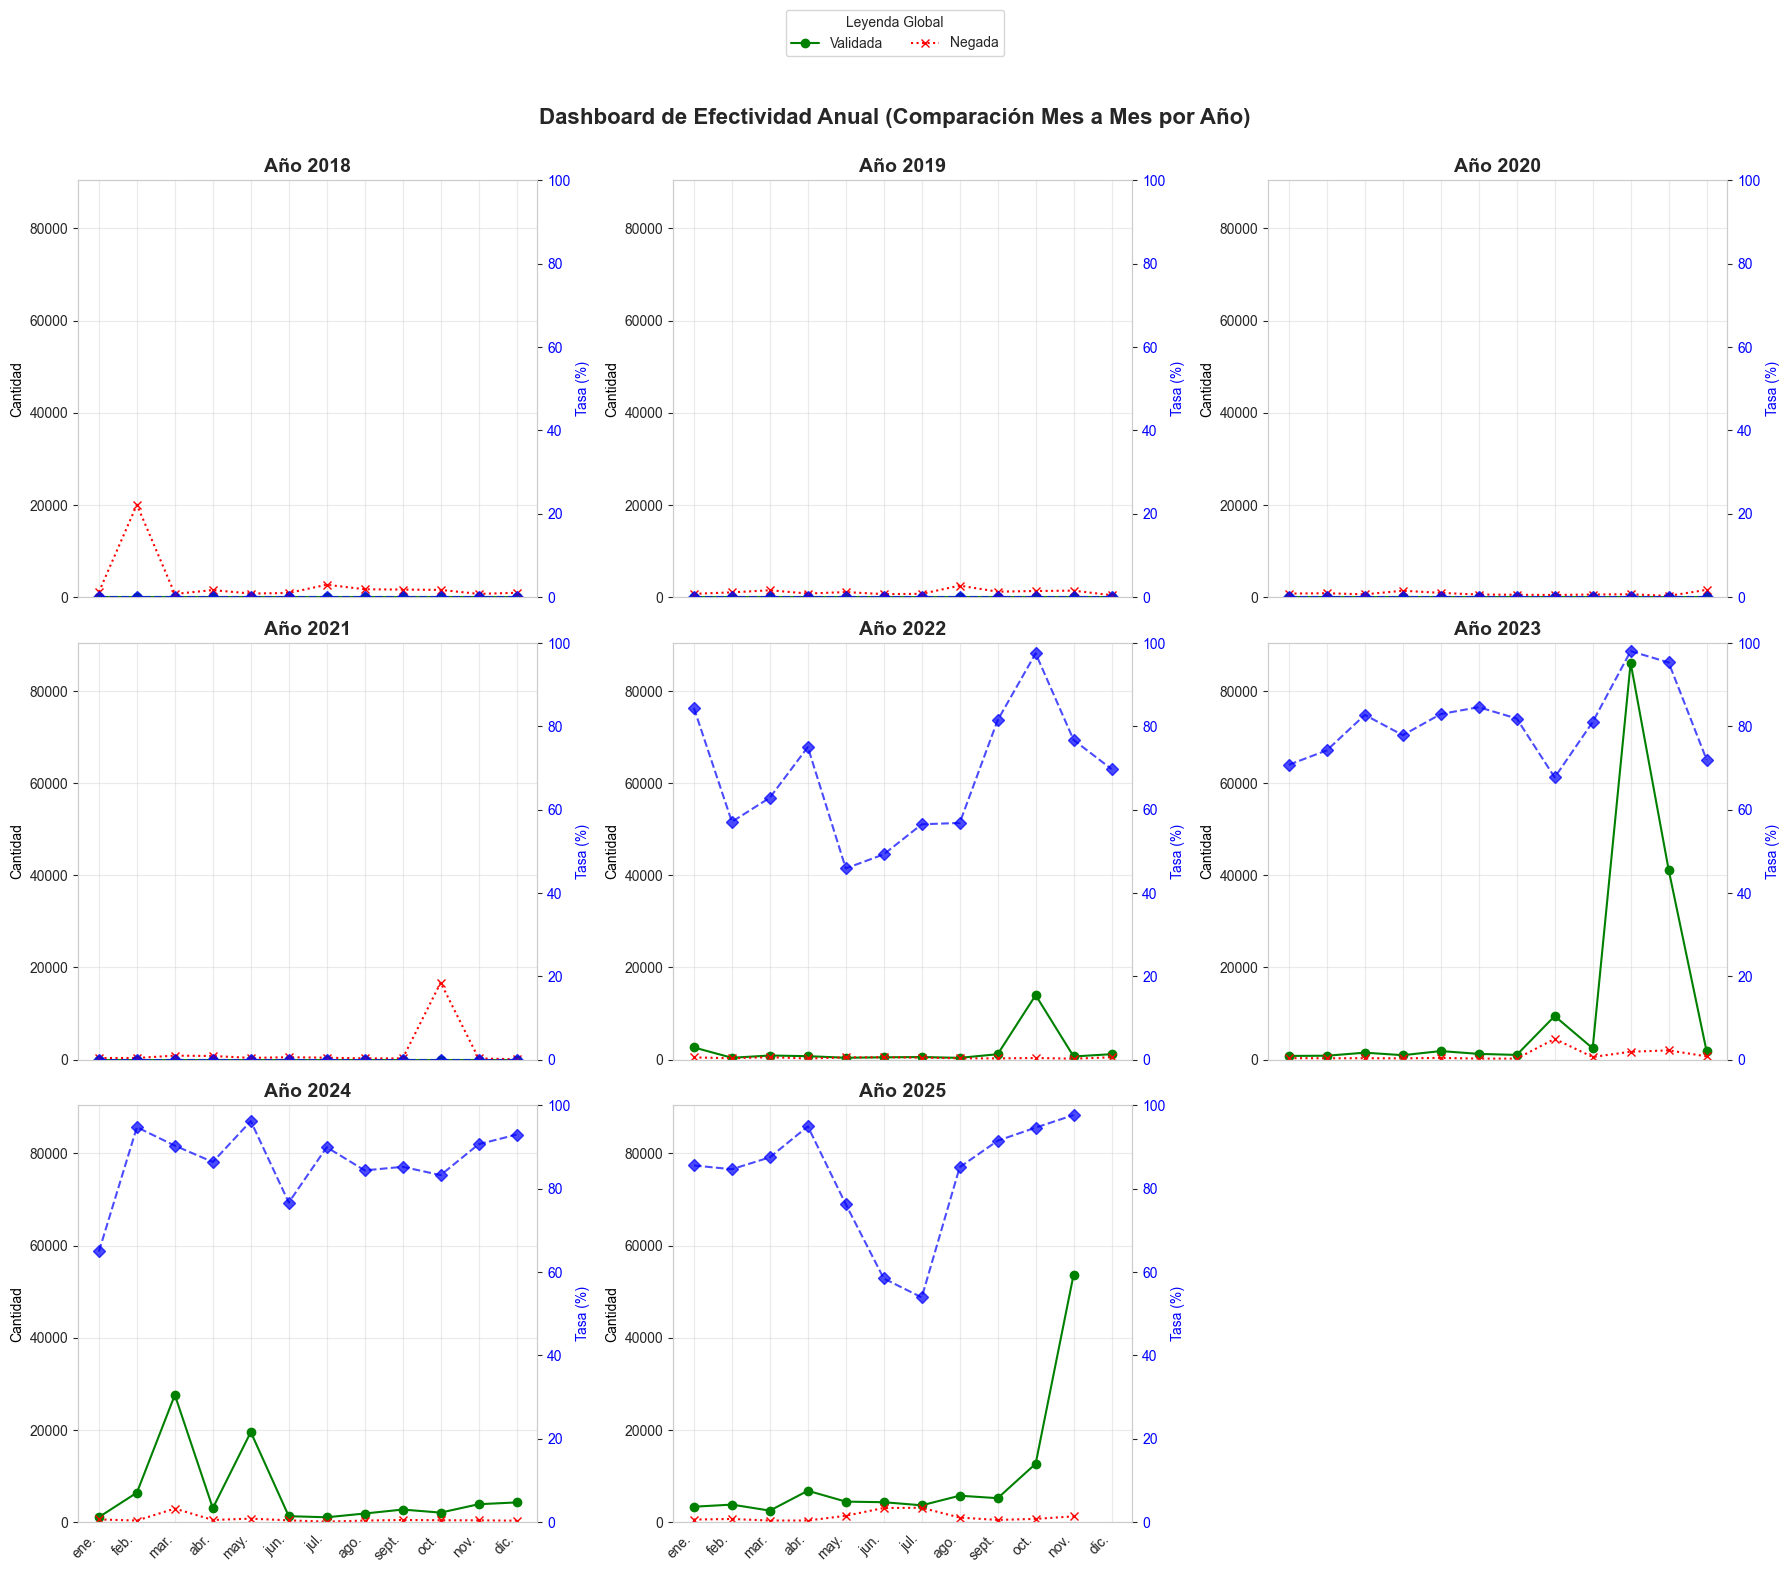

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# --- 1. Preparación de DataFrames y Conversión de Fechas ---

# Crear columna de tipo de registro en ambos DataFrames
# Asumo que df_ns y df_ns_neg existen en tu entorno de trabajo.
df_ns['Tipo'] = 'Validada'
df_ns_neg['Tipo'] = 'Negada'

# Convertir la columna de fecha a formato datetime
# Se utiliza el formato '%d/%m/%Y' basado en tu código inicial
df_ns['Fecha_Proceso'] = pd.to_datetime(df_ns['Fecha_Proceso'], format='%d/%m/%Y')
df_ns_neg['Fecha_Proceso'] = pd.to_datetime(df_ns_neg['Fecha_Proceso'], format='%d/%m/%Y')

# Unir ambos DataFrames
df_comparativo = pd.concat([df_ns[['Fecha_Proceso', 'Tipo']], df_ns_neg[['Fecha_Proceso', 'Tipo']]], ignore_index=True)

# --- 2. Preparación para la Comparación Anual (Mes vs. Año) ---

# Crear columnas de Año y Mes (como número)
df_comparativo['Año'] = df_comparativo['Fecha_Proceso'].dt.year
df_comparativo['Mes_Num'] = df_comparativo['Fecha_Proceso'].dt.month
df_comparativo['Mes_Label'] = df_comparativo['Fecha_Proceso'].dt.strftime('%b') 

# Agrupar por Año, Mes y Tipo, contar registros
efectividad_anual_comp = df_comparativo.groupby(['Año', 'Mes_Num', 'Mes_Label', 'Tipo']).size().unstack(fill_value=0).reset_index()

# Calcular la Tasa de Efectividad (%)
efectividad_anual_comp['Tasa_Efectividad'] = (efectividad_anual_comp['Validada'] / (efectividad_anual_comp['Validada'] + efectividad_anual_comp['Negada'])) * 100

# --- 3. Generación del Dashboard de Subgráficos Anuales (Small Multiples) ---

# Obtener los años únicos para iterar
años = sorted(efectividad_anual_comp['Año'].unique())
num_años = len(años)

# Definir la disposición de la cuadrícula (ej. 3 filas, N columnas)
# Usamos int(np.ceil(num_años / 3)) para calcular dinámicamente el número de columnas
ncols = 3
nrows = int(np.ceil(num_años / ncols))

# Crear la figura y los subgráficos
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), sharex=True)

# Asegurar que 'axes' sea un array plano si solo hay una fila/columna para facilitar la iteración
axes = axes.flatten() if num_años > 1 else np.array([axes])

# Determinar el valor máximo global para el eje Y de Cantidad
max_cantidad = efectividad_anual_comp[['Validada', 'Negada']].max().max()

# Etiquetas de los meses
meses_labels = [pd.to_datetime(str(m), format='%m').strftime('%b') for m in range(1, 13)]


for i, año in enumerate(años):
    # Seleccionar el subplot actual (ax)
    ax1 = axes[i]
    
    # Crear un segundo eje Y (ax2) para la Tasa de Efectividad
    ax2 = ax1.twinx() 
    
    df_año = efectividad_anual_comp[efectividad_anual_comp['Año'] == año]
    
    # 3.1. Graficar Validada y Negada (Eje Y Principal - Ax1)
    ax1.plot(df_año['Mes_Num'], df_año['Validada'], label='Validada', marker='o', color='green', linestyle='-')
    ax1.plot(df_año['Mes_Num'], df_año['Negada'], label='Negada', marker='x', color='red', linestyle=':')
    
    # 3.2. Graficar Tasa de Efectividad (Eje Y Secundario - Ax2)
    ax2.plot(df_año['Mes_Num'], df_año['Tasa_Efectividad'], label='Tasa (%)', marker='D', color='blue', linestyle='--', alpha=0.7)
    
    # --- Configuración del Subgráfico ---
    
    # Asegurar escalas consistentes para facilitar la comparación entre años (Buena práctica de visualización)
    ax1.set_ylim(0, max_cantidad * 1.05) # Escala de Cantidad
    ax2.set_ylim(0, 100) # Escala de Tasa de Efectividad
    
    # Título y etiquetas
    ax1.set_title(f'Año {año}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Cantidad', color='black')
    ax2.set_ylabel('Tasa (%)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    
    # Configurar Eje X para mostrar los nombres de los meses
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(meses_labels, rotation=45, ha='right')
    
    ax1.grid(True, alpha=0.4)
    ax2.grid(False)

# Ocultar subgráficos vacíos si el número de años no llena la cuadrícula
for j in range(num_años, nrows * ncols):
    fig.delaxes(axes[j])
    
# Leyenda unificada (se usa la leyenda del primer gráfico y se ajusta)
h1, l1 = axes[0].get_legend_handles_labels()
h2, l2 = axes[0].get_legend_handles_labels() # Reutilizar legend_handles
fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, title='Leyenda Global')
    
fig.suptitle('Dashboard de Efectividad Anual (Comparación Mes a Mes por Año)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Ajustar para el título superior
plt.show()

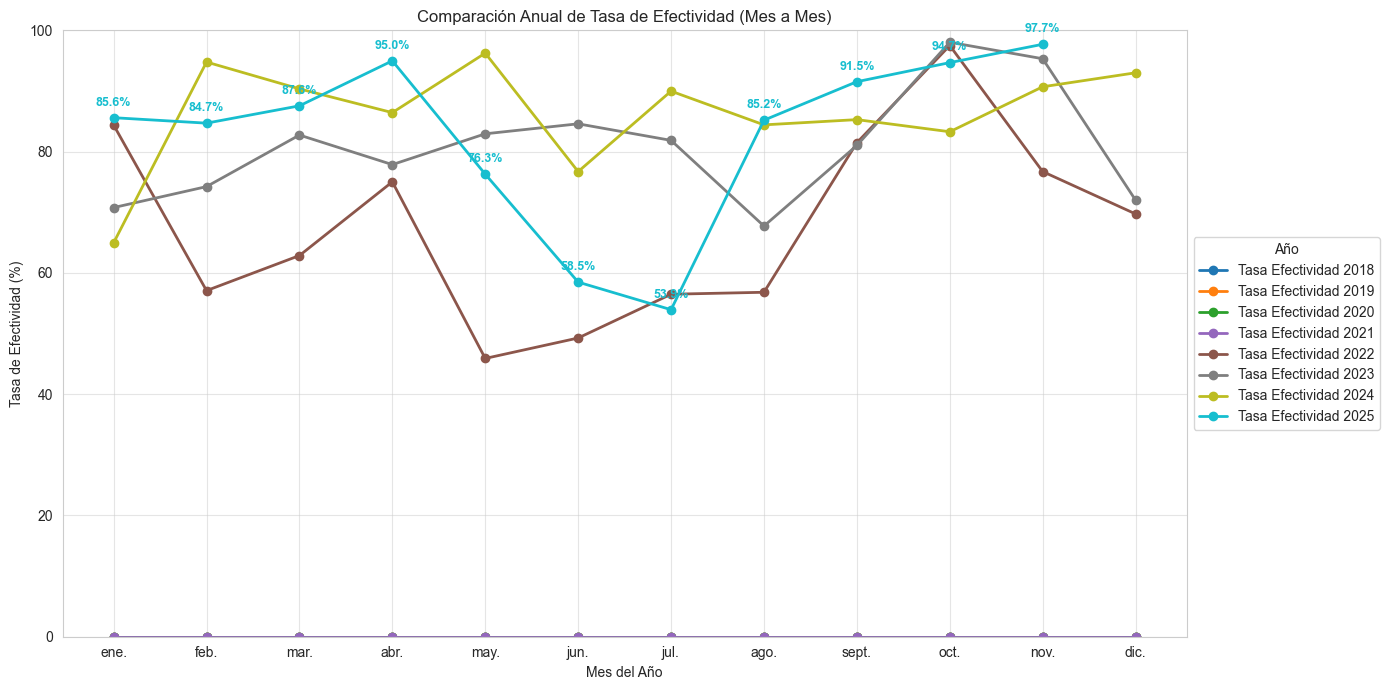

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# --- 1. Preparación de DataFrames y Conversión de Fechas ---
# ... (Este bloque permanece sin cambios) ...
df_ns['Tipo'] = 'Validada'
df_ns_neg['Tipo'] = 'Negada'

df_ns['Fecha_Proceso'] = pd.to_datetime(df_ns['Fecha_Proceso'], format='%d/%m/%Y')
df_ns_neg['Fecha_Proceso'] = pd.to_datetime(df_ns_neg['Fecha_Proceso'], format='%d/%m/%Y')

df_comparativo = pd.concat([df_ns[['Fecha_Proceso', 'Tipo']], df_ns_neg[['Fecha_Proceso', 'Tipo']]], ignore_index=True)

# --- 2. Preparación para la Comparación Anual (Mes vs. Año) ---
# ... (Este bloque permanece sin cambios) ...
df_comparativo['Año'] = df_comparativo['Fecha_Proceso'].dt.year
df_comparativo['Mes_Num'] = df_comparativo['Fecha_Proceso'].dt.month
df_comparativo['Mes_Label'] = df_comparativo['Fecha_Proceso'].dt.strftime('%b') 

efectividad_anual_comp = df_comparativo.groupby(['Año', 'Mes_Num', 'Mes_Label', 'Tipo']).size().unstack(fill_value=0).reset_index()

efectividad_anual_comp['Tasa_Efectividad'] = (efectividad_anual_comp['Validada'] / (efectividad_anual_comp['Validada'] + efectividad_anual_comp['Negada'])) * 100

# --- 3. Generación del Gráfico Limpio de Tasa de Efectividad Mes a Mes (CON ETIQUETAS) ---

años = sorted(efectividad_anual_comp['Año'].unique())
num_años = len(años)
# Identificar el año más reciente para aplicar etiquetas (último en la lista ordenada)
año_reciente = años[-1]

colores = plt.cm.tab10(np.linspace(0, 1, num_años))
meses_labels = [pd.to_datetime(str(m), format='%m').strftime('%b') for m in range(1, 13)]


plt.figure(figsize=(14, 7))
ax = plt.gca()

# Iterar sobre cada año para graficar
for i, año in enumerate(años):
    df_año = efectividad_anual_comp[efectividad_anual_comp['Año'] == año]
    color_line = colores[i]
    
    # Graficar la Tasa de Efectividad
    ax.plot(
        df_año['Mes_Num'], 
        df_año['Tasa_Efectividad'], 
        color=color_line, 
        marker='o', 
        linestyle='-', 
        linewidth=2,
        label=f'Tasa Efectividad {año}'
    )
    
    # 💡 IMPLEMENTACIÓN DE ETIQUETAS: Solo para el año más reciente (2025)
    if año == año_reciente:
        for x, y in zip(df_año['Mes_Num'], df_año['Tasa_Efectividad']):
            # Usar una pequeña compensación vertical (y+2) para que la etiqueta no tape el punto
            ax.text(
                x, 
                y + 2, 
                f'{y:.1f}%', # Formatear a un decimal
                fontsize=9, 
                color=color_line,
                ha='center', # Alineación horizontal centrada
                fontweight='bold'
            )
    
# --- Configuración Final del Gráfico ---
ax.set_xlabel('Mes del Año')
ax.set_ylabel('Tasa de Efectividad (%)')
ax.set_title('Comparación Anual de Tasa de Efectividad (Mes a Mes)')

# Configurar Eje X
ax.set_xticks(range(1, 13))
ax.set_xticklabels(meses_labels)

# Configurar Eje Y
ax.set_ylim(0, 100) 
ax.grid(True, alpha=0.5)

# Posicionar la leyenda fuera del área de trazado
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="Año")

plt.tight_layout()
plt.show()

# NEgados

Registros por mes y año:
Año     2018   2019  2020   2021  2022   2023  2024   2025   Total
Mes                                                               
1       1122    726   774    352   490    334   591    564    4953
2      20057   1038   848    372   309    296   352    688   23960
3        696   1492   616    872   531    316  2946    356    7825
4       1534    782  1387    795   252    276   477    360    5863
5        778   1099   928    385   488    383   761   1385    6207
6        907    658   559    523   520    228   394   3075    6864
7       2697    721   519    429   436    228   118   3124    8272
8       1712   2502   471    278   298   4505   346    998   11110
9       1643   1186   572    268   268    578   472    481    5468
10      1573   1334   624  16716   358   1717   416    711   23449
11       706   1413   276    276   210   2021   399   1259    6560
12       949    426  1585     81   517    715   322      0    4595
Total  34374  13377  9159  21347  467

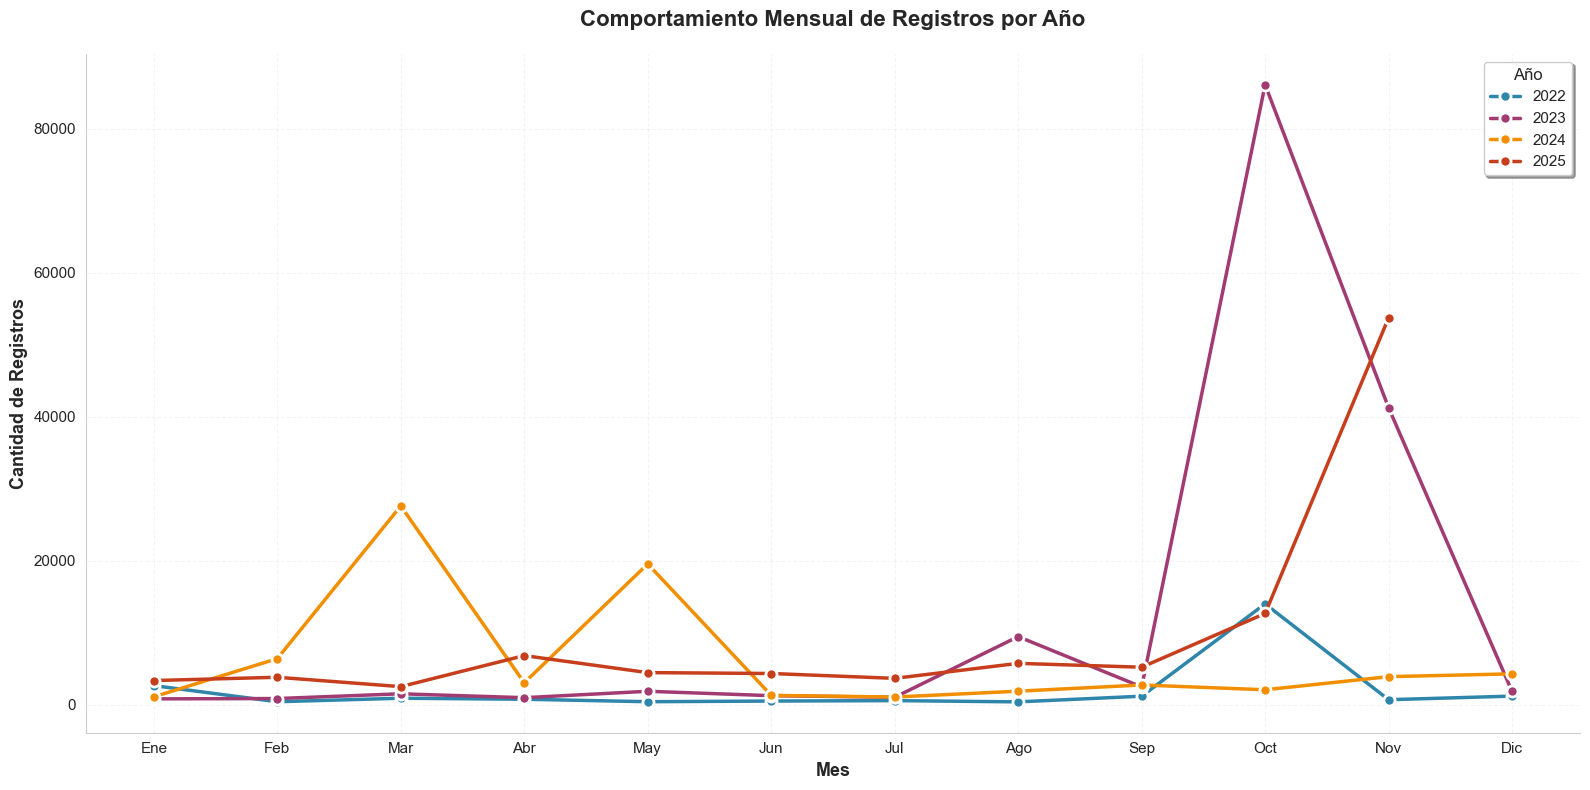

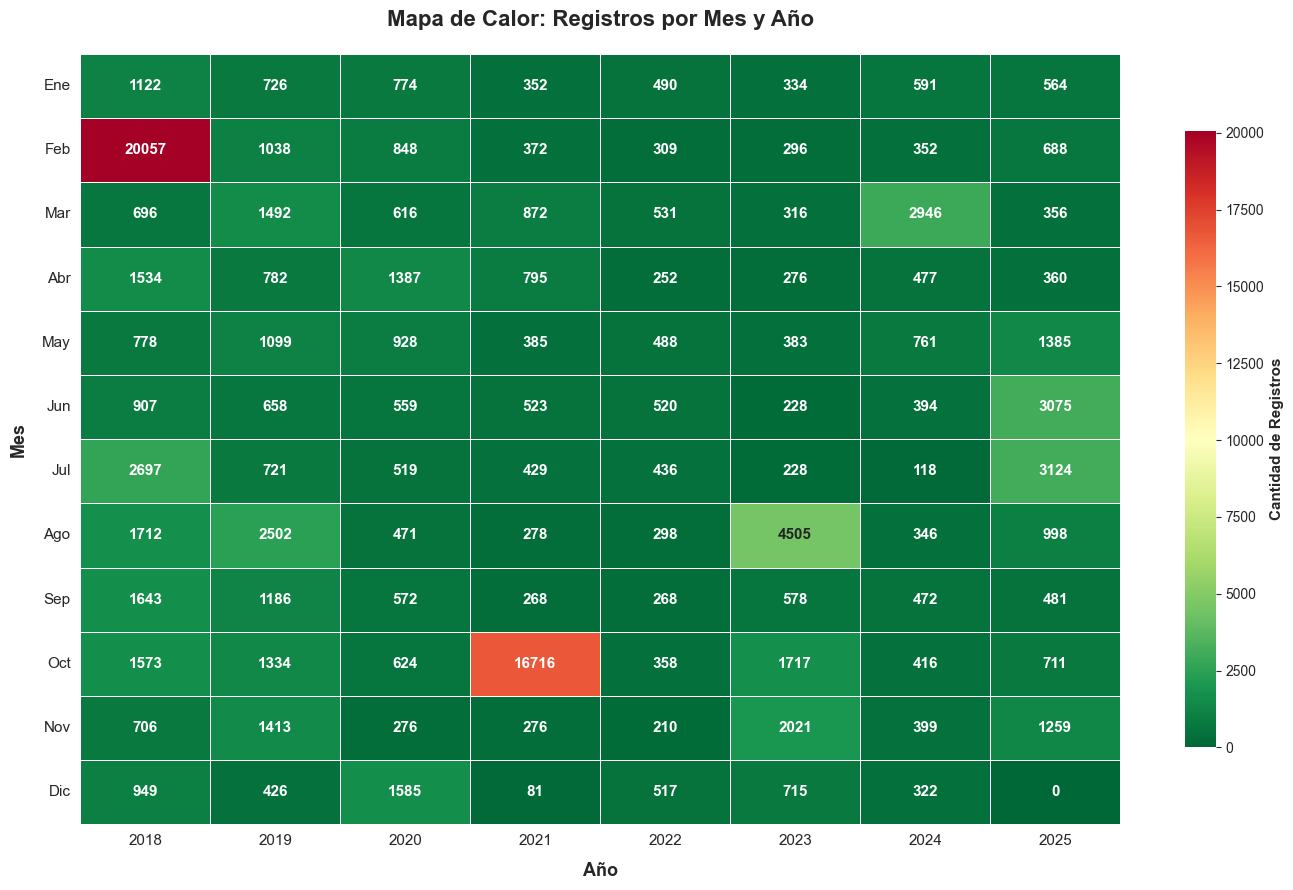

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo general
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Extraer mes y año de Fecha_Proceso
df_ns_neg['Mes'] = df_ns_neg['Fecha_Proceso'].dt.month
df_ns_neg['Año'] = df_ns_neg['Fecha_Proceso'].dt.year
df_ns_neg['Año_Mes'] = df_ns_neg['Fecha_Proceso'].dt.to_period('M')

# Crear tabla de registros por mes y año
registros_mes_año = pd.crosstab(df_ns_neg['Mes'], df_ns_neg['Año'], margins=True, margins_name='Total')
print("Registros por mes y año:")
print(registros_mes_año)

# Definir paleta de colores personalizada
colores = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

# Crear gráfica de líneas mejorada
plt.figure(figsize=(16, 8))
ax = plt.gca()

# Graficar cada año con estilo mejorado
for idx, año in enumerate(sorted(df_ns['Año'].unique())):
    datos_año = df_ns[df_ns['Año'] == año].groupby('Mes').size()
    plt.plot(datos_año.index, datos_año.values, 
             marker='o', label=f'{año}', linewidth=2.5, 
             color=colores[idx % len(colores)], markersize=8,
             markeredgewidth=2, markeredgecolor='white')

plt.xlabel('Mes', fontsize=13, fontweight='bold')
plt.ylabel('Cantidad de Registros', fontsize=13, fontweight='bold')
plt.title('Comportamiento Mensual de Registros por Año', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Año', fontsize=11, title_fontsize=12, 
           frameon=True, shadow=True, fancybox=True)
plt.xticks(range(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                          'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'],
           fontsize=11)
plt.yticks(fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, alpha=0.2, linestyle='--')
plt.tight_layout()
plt.show()

# Crear heatmap mejorado
plt.figure(figsize=(14, 9))

# Preparar datos sin totales para el heatmap
datos_heatmap = registros_mes_año.iloc[:-1, :-1]

# Crear heatmap con mejor estética
ax = sns.heatmap(datos_heatmap, annot=True, fmt='d', 
                 cmap='RdYlGn_r', linewidths=0.5, linecolor='white',
                 cbar_kws={'label': 'Cantidad de Registros', 'shrink': 0.8},
                 annot_kws={'size': 11, 'weight': 'bold'},
                 xticklabels=datos_heatmap.columns,
                 yticklabels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
                             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])

plt.xlabel('Año', fontsize=13, fontweight='bold', labelpad=10)
plt.ylabel('Mes', fontsize=13, fontweight='bold', labelpad=10)
plt.title('Mapa de Calor: Registros por Mes y Año', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)

# Mejorar colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Cantidad de Registros', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()